In [1]:
import numpy as np
from imports import *


# parameters = {'xtick.labelsize': 6, 'ytick.labelsize': 6,
#           'axes.titlesize': 25, 'axes.labelsize': 5, 'figure.titlesize': 15, 'legend.fontsize': 7}
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#    "font.serif": "cm"
#     })
# plt.rcParams.update(parameters)




In [2]:
def generate_stempo2(data_set = 'real', data_thinning = 2,new_shape= (64,64), **kwargs):
        """
        Generate stempo observations
        """
        nt = kwargs['nt'] if ('nt' in kwargs) else 10
        noise_level = kwargs['noise_level'] if ('noise_level' in kwargs) else 0
        data_file = {'simulation':'stempo_ground_truth_2d_b4','real':'stempo_seq8x45_2d_b'+str(data_thinning)}[data_set]+'.mat'
        if not os.path.exists('./data/stempo_data'): os.makedirs('./data/stempo_data/')
        if not os.path.isfile('./data/stempo_data/'+data_file):
            import requests
            print("downloading...")
            r = requests.get('https://zenodo.org/record/7147139/files/'+data_file)
            with open('./data/stempo_data/'+data_file, "wb") as file:
                file.write(r.content)
            print("Stempo data downloaded.")
        if data_set=='simulation':
            truth = spio.loadmat('./data/stempo_data/'+data_file)
            image = truth['obj']
            nx= new_shape[0]
            ny= new_shape[1]
            temp =np.zeros((nx, ny, 360))
            for i in range(360):
                img = image[:, :, i]
                imm = image_to_new_size(img, (nx, ny))
                temp[:, :, i] = imm # imm.flatten()
            temp[np.isnan(temp)] = 0
            image = temp

            savex_true = np.zeros((nx*ny, nt))
            count = int(360/nt)

            for i in range(nt):

                x_true = image[:, :, count*i]*1000
                x_truef_sino = x_true.flatten(order='F')
                savex_true[:, i] = x_truef_sino
            truth = savex_true.reshape((nx, ny, nt), order='F').transpose((2,1,0))

        return truth

In [3]:
from trips.solvers.MMGKS import *

In [4]:
truth_ = generate_stempo2(data_set = 'simulation', data_thinning = 2, nt=30,new_shape=(64,64))

In [29]:
Tomo = Tomography()

#Specify the shape of the images, the number of images in the sequence and load the image sequence using the gen_seq_function
nx= 64
ny = nx
shape = (nx,ny)
size = nx*ny
t_end = 5

v_max = 2
v_min = 1
padding = 5
data = gen_im_seq(shape,t_end,v_max=v_max,v_min=v_min, padding =padding)
u_traj = data.u_traj
u_inv_traj = data.u_inv_traj
v_primes=data.v_primes
vs=data.vs

# A list of the locations of all pixels
R = np.array(list(np.ndindex(*shape)))


truth = truth_[5:5+t_end]
u_traj = [vec(u) for u in truth]

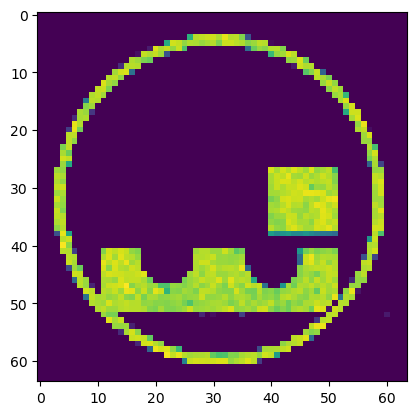

In [33]:
plt.imshow(truth[0].reshape(shape))

In [30]:
u_inv_traj=u_traj[::-1]

In [57]:
n_iter = 100
v_av = 2 # v_max#math.ceil((v_min+v_max)/2)
scale = 2
if (scale ==1): 
    v_trues = None # vs
else: 
    v_trues = None
v_ests_,v_larges_,info_v_b  = solve_opt_flow(u_traj,shape=shape,t_end=t_end,v_trues = v_trues,v_max=v_av, n_iter = n_iter,reduction=True,scale=scale,pnorm= 1, qnorm=1,proj_dim=5)

nx_= nx//scale; ny_=nx_
# v_ests= v_ests_ * np.sqrt(scale)
# v_larges = v_larges_ * scale
v_ests = []; v_larges =[]
for v in v_ests_:
    v = v.reshape(nx_,nx_,2)
    v = v*(scale)
    v[0,:] = np.zeros(2); v[:,0] = np.zeros(2); v[:,nx_-1] = np.zeros(2); v[nx_-1,:] = np.zeros(2)
    v_ests.append(v)
for v in v_larges_:
    v = v.reshape(nx,ny,2)
    v = v#*(scale)
    v[0,:] = np.zeros(2); v[:,0] = np.zeros(2); v[:,nx-1] = np.zeros(2); v[nx-1,:] = np.zeros(2)
    v_larges.append(v)

# v_ests[v_ests>v_max] = v_max
# v_ests[v_ests<-v_max] = -v_max

v_ests_b = [np.rint(v_ests[(len(v_ests)//(t_end-1))*t:(len(v_ests)//(t_end-1)*(t+1))]) for t in range(t_end-1)]
v_ests_c = [np.rint(v_larges[(len(v_larges)//(t_end-1))*t:(len(v_larges_)//(t_end-1)*(t+1))]) for t in range(t_end-1)]



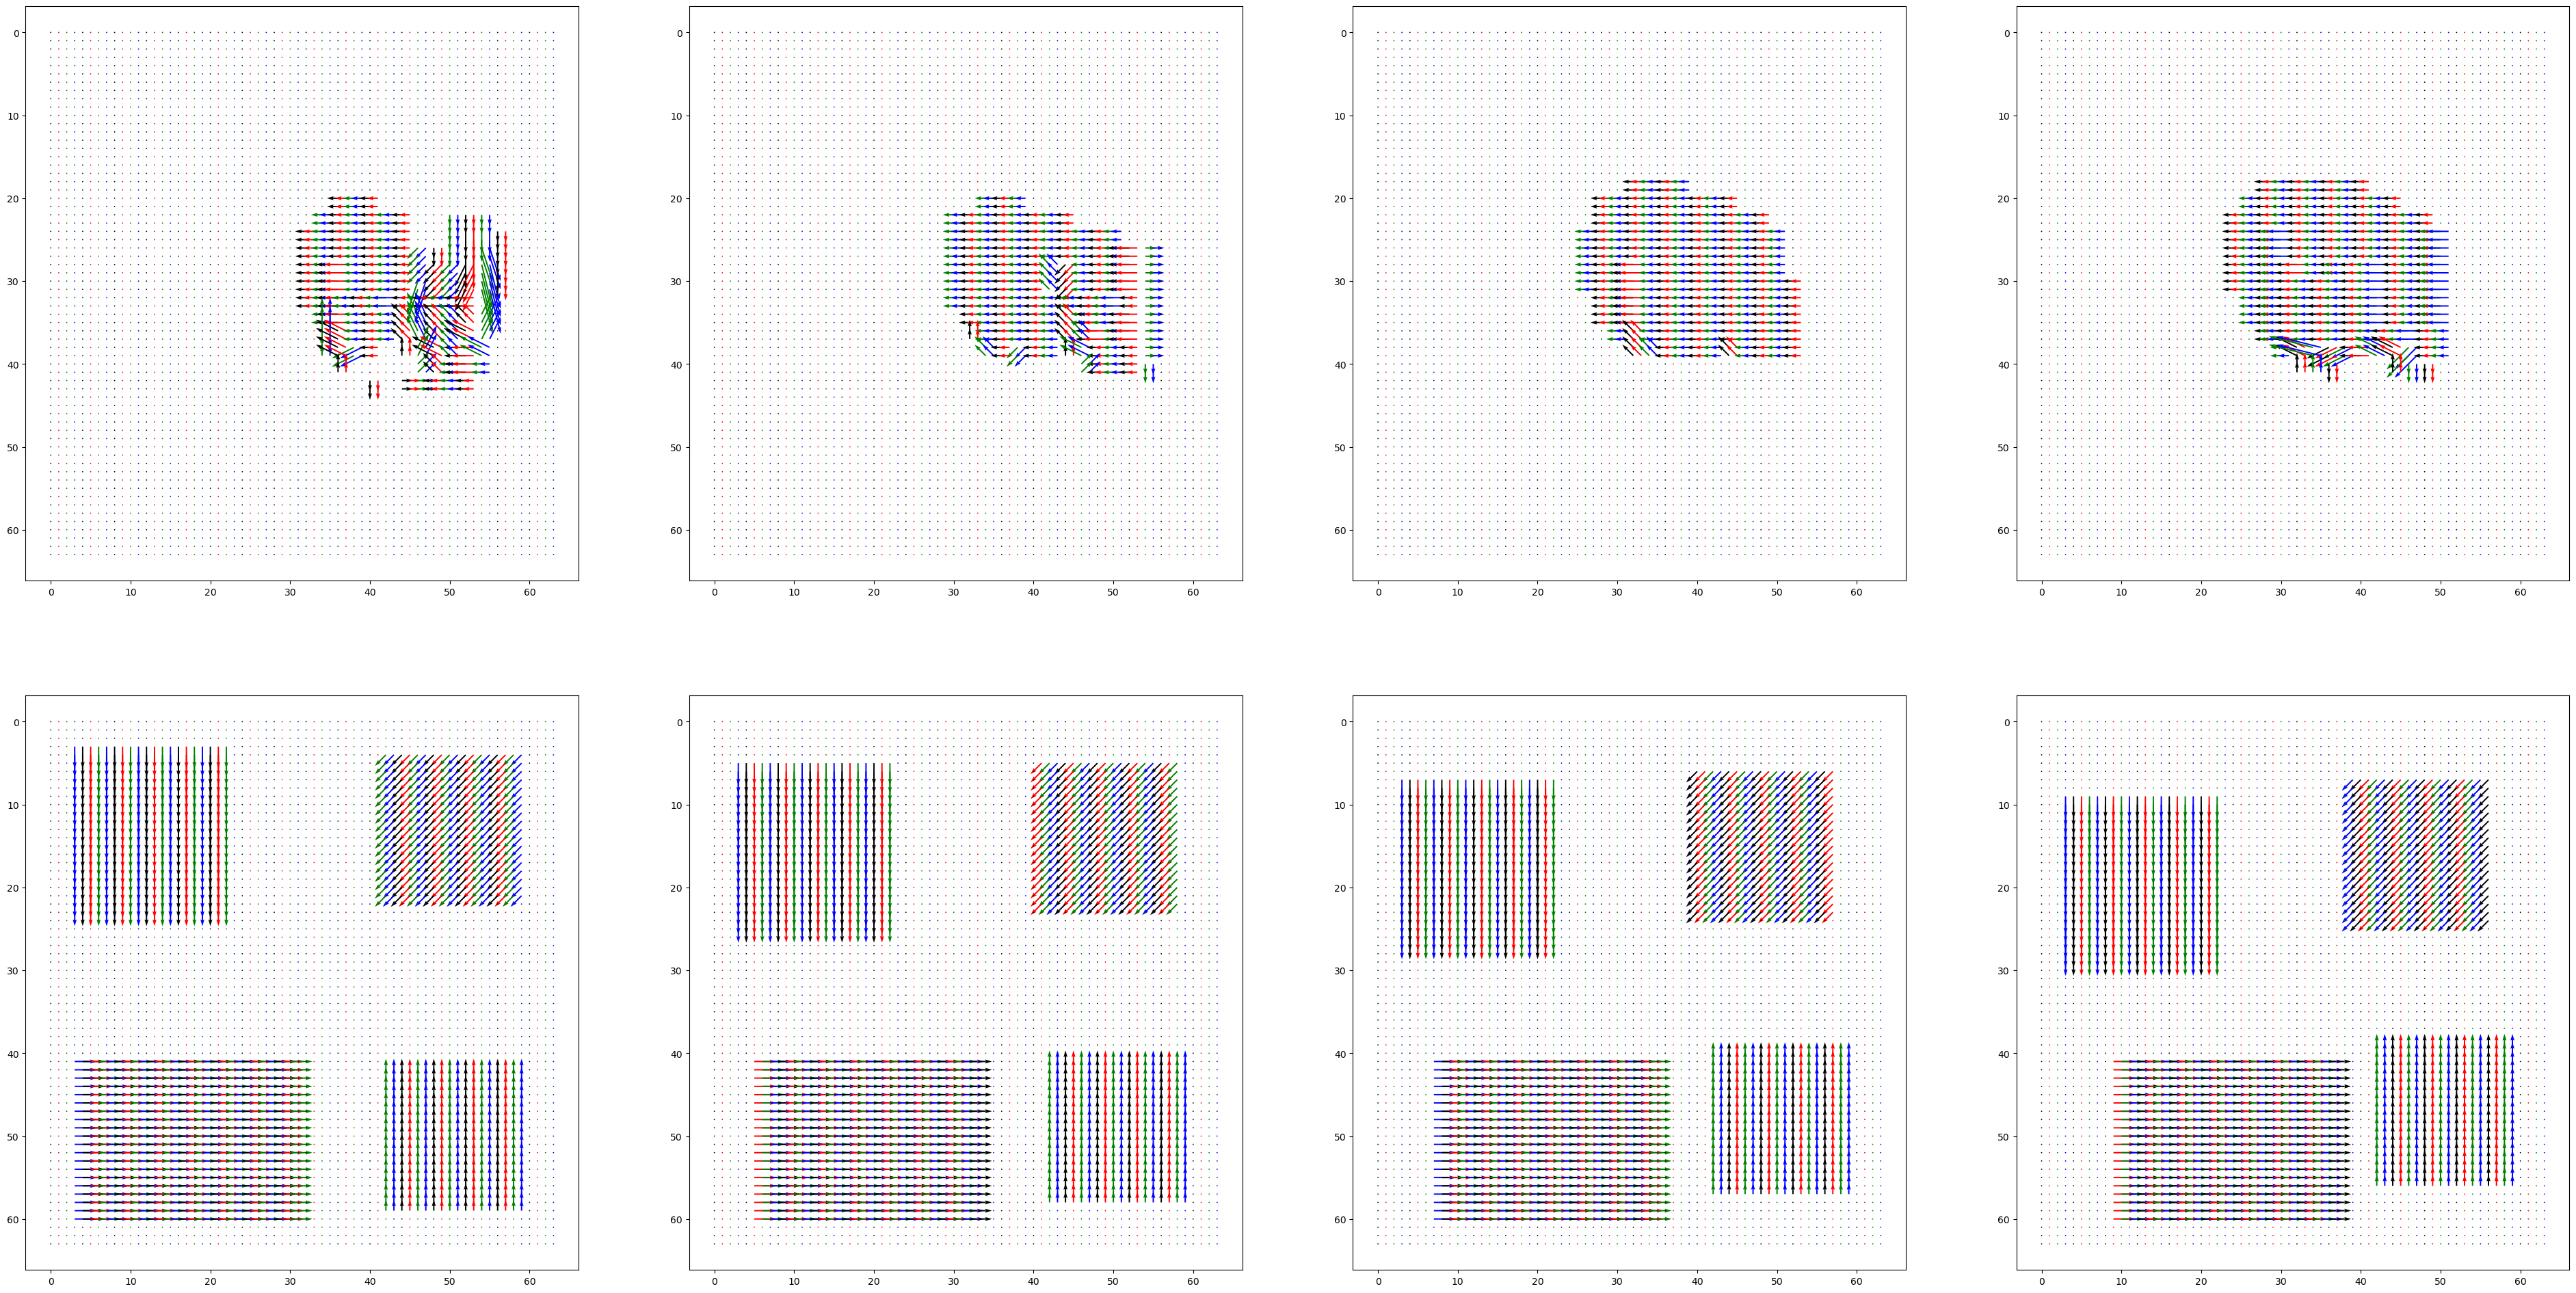

In [58]:
# nx_=64
data_inv = [vs[i].reshape((nx**2,2)) for i in range(t_end-1)]
data_ = [(v_ests_c[i]).reshape((nx**2,2)) for i in range(t_end-1)]

origin = [np.array(R)[:,1], np.array(R)[:,0]]

R_ = np.array(list(np.ndindex(*(nx_,nx_))))
origin_ = [np.array(R_)[:,1], np.array(R_)[:,0]]
#plt.quiver(u_traj[i]_im,v_x.reshape(shape),v_y.reshape(shape), 
# color='g')
fig,ax=plt.subplots(2,t_end-1,figsize=(6*2*(t_end-1),3*2*(t_end-1)))
if (t_end <=2):
    ax = ax.reshape((-1,1))
for i in range(len(data_)):
    ax[0,i].quiver(*origin, data_[i][:, 1], -data_[i][:, 0], color=['black', 'red', 'green','blue'],scale=50)
    ax[0,i].invert_yaxis()
    ax[1,i].invert_yaxis()
    ax[1,i].quiver(*origin, data_inv[i][:, 1], -data_inv[i][:, 0], color=['black', 'red', 'green','blue'],scale=50)


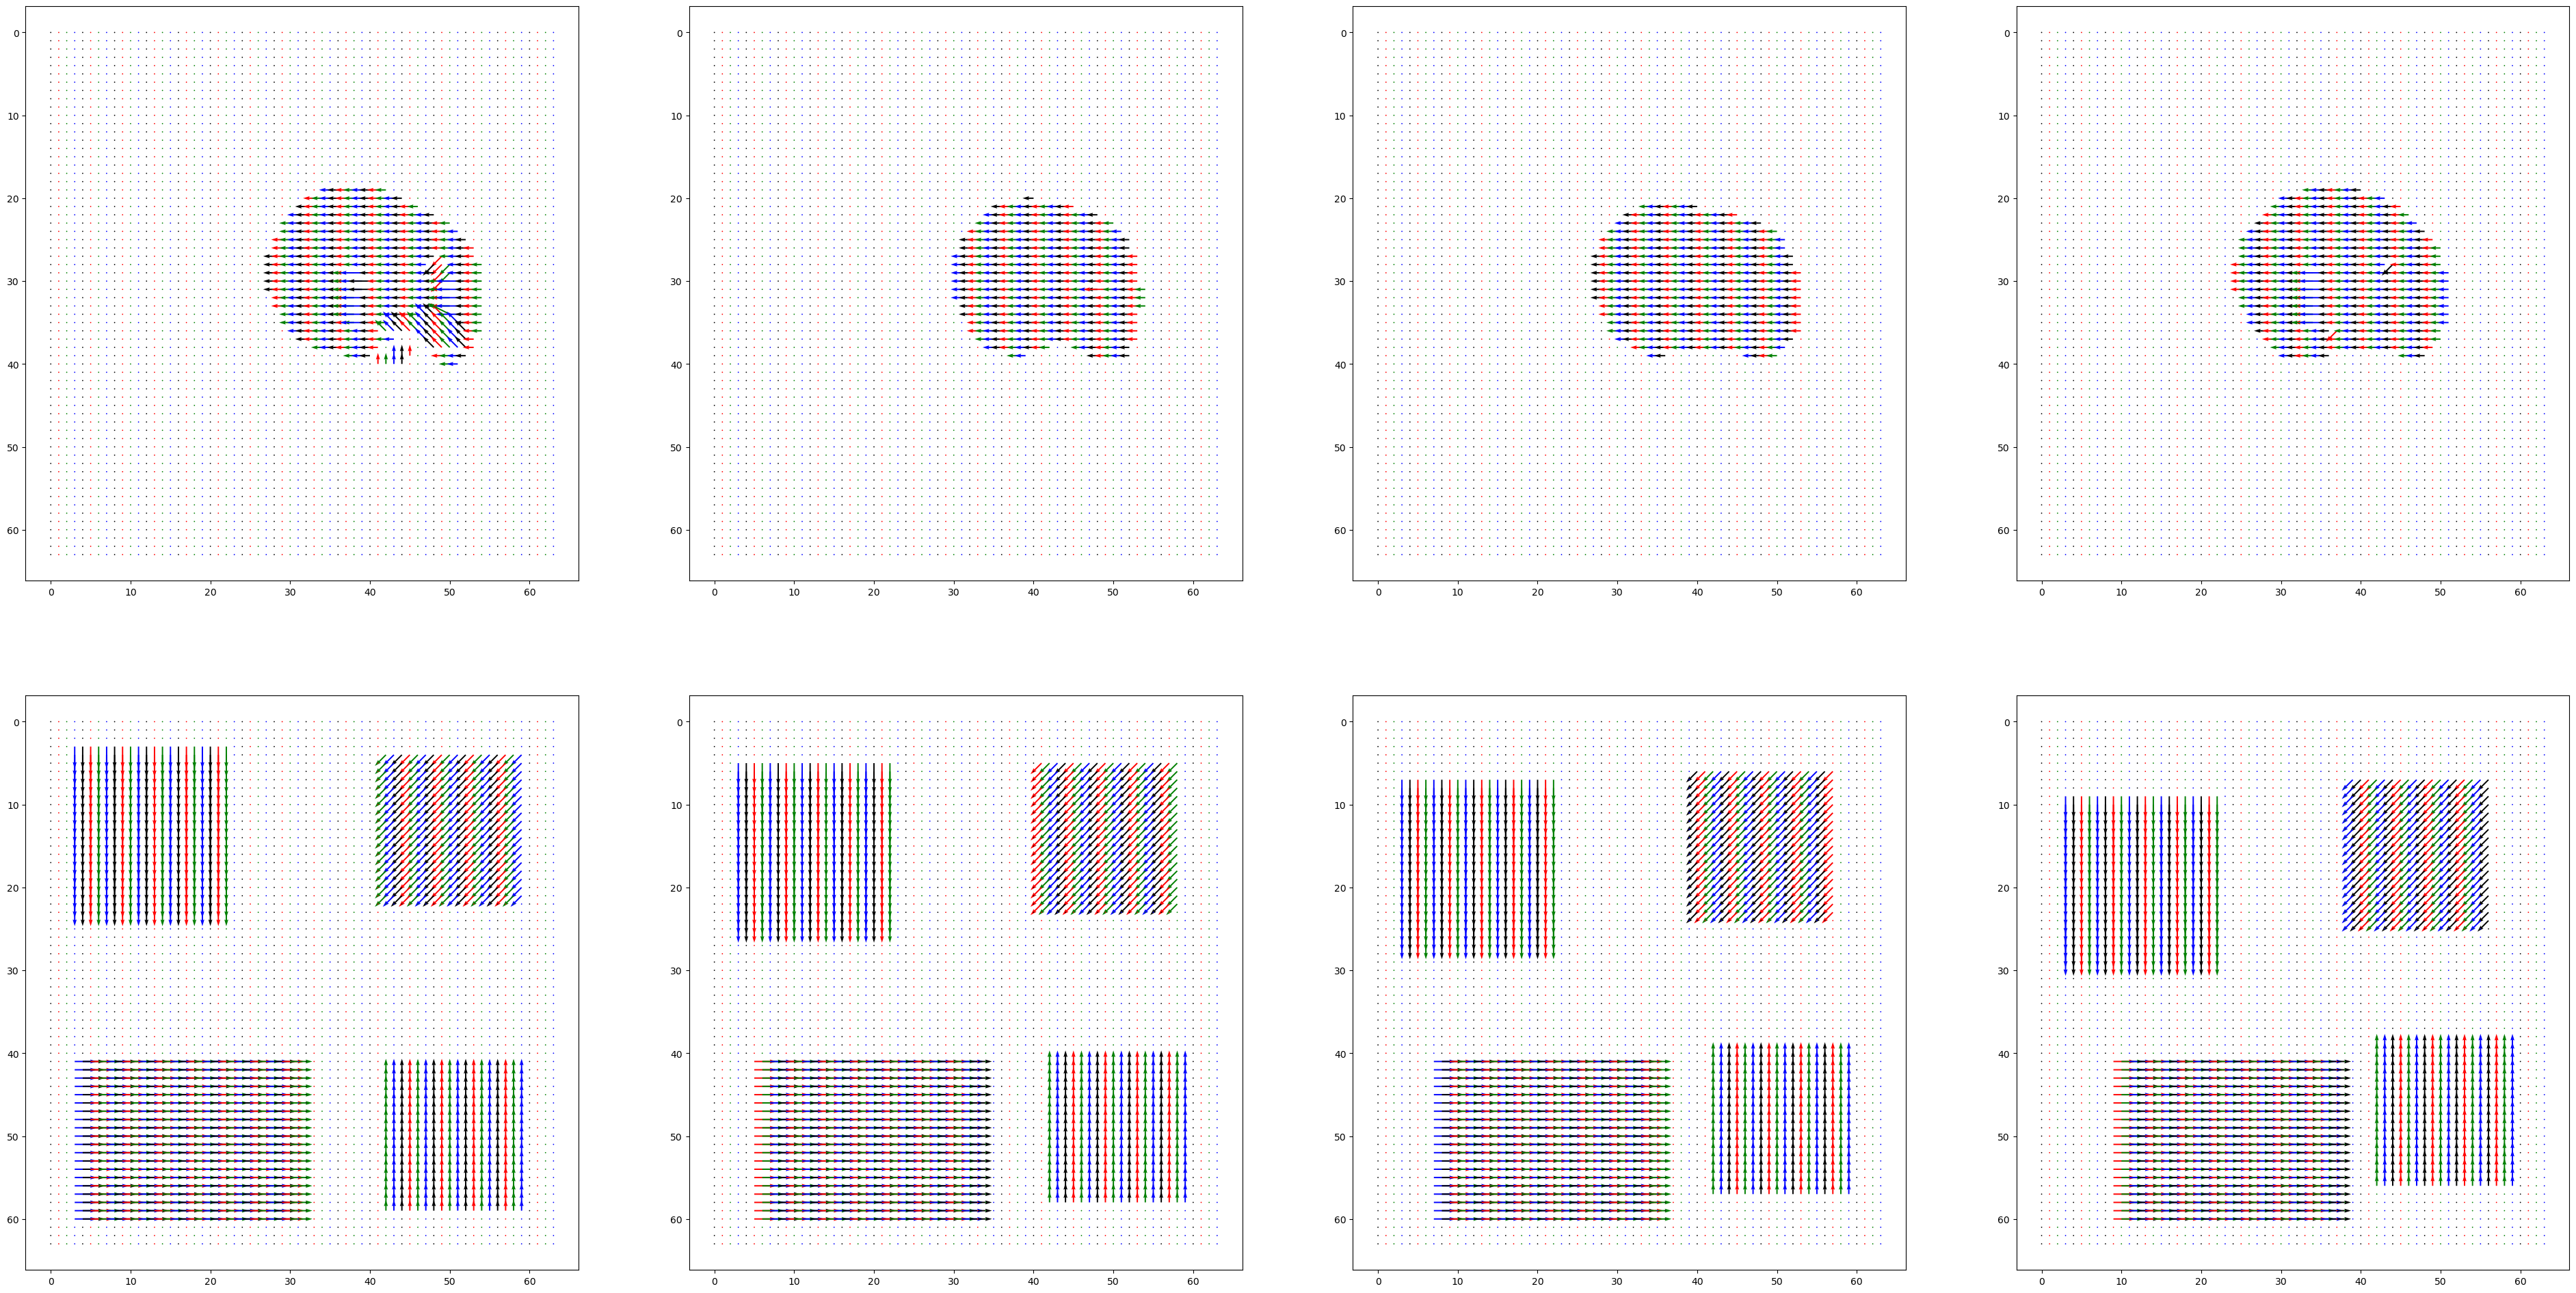

In [52]:
# nx_=64
data_inv = [vs[i].reshape((nx**2,2)) for i in range(t_end-1)]
data_ = [(v_ests_c[i]).reshape((nx**2,2)) for i in range(t_end-1)]

origin = [np.array(R)[:,1], np.array(R)[:,0]]

R_ = np.array(list(np.ndindex(*(nx_,nx_))))
origin_ = [np.array(R_)[:,1], np.array(R_)[:,0]]
#plt.quiver(u_traj[i]_im,v_x.reshape(shape),v_y.reshape(shape), 
# color='g')
fig,ax=plt.subplots(2,t_end-1,figsize=(6*2*(t_end-1),3*2*(t_end-1)))
if (t_end <=2):
    ax = ax.reshape((-1,1))
for i in range(len(data_)):
    ax[0,i].quiver(*origin, data_[i][:, 1], -data_[i][:, 0], color=['black', 'red', 'green','blue'],scale=50)
    ax[0,i].invert_yaxis()
    ax[1,i].invert_yaxis()
    ax[1,i].quiver(*origin, data_inv[i][:, 1], -data_inv[i][:, 0], color=['black', 'red', 'green','blue'],scale=50)


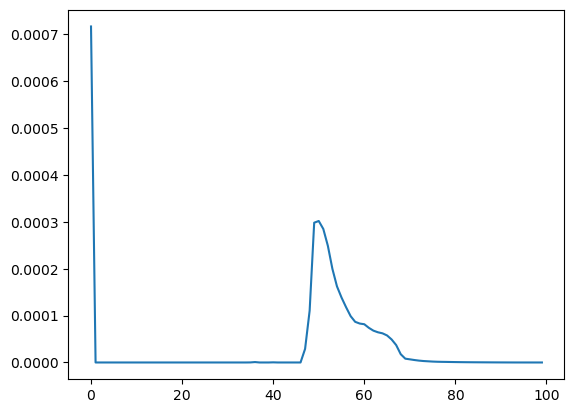

In [120]:
plt.plot(info_v_b['regParam_history'])

0.21682144240864581 1.1222083678834476
0.1239786950134697 1.0536324375147192
0.1402444874881445 1.0624709667931969
0.1756554452319146 1.102027150481785


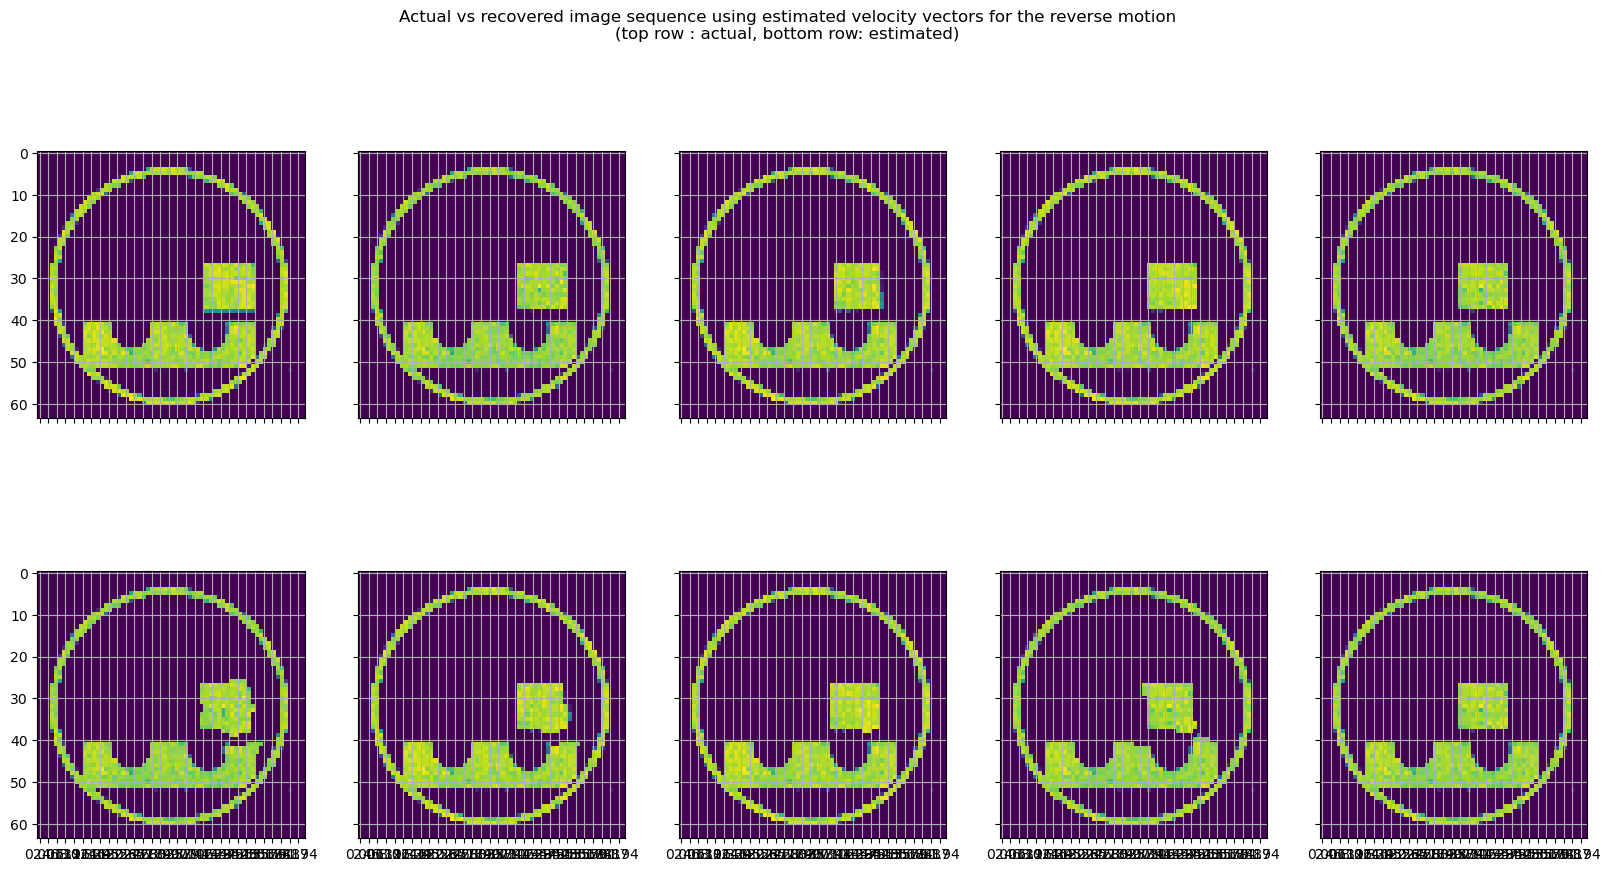

In [59]:
fig,ax=plt.subplots(2,t_end,figsize=(20,10),sharex=True, sharey=True)
vel_shape = shape[0],shape[1],2
#u_traj.reverse()
rec = [u_inv_traj[0].reshape(shape)] + [M(u_inv_traj[i].reshape(shape),(v_ests_c[::-1][i]).reshape(vel_shape)).reshape(shape) for i in range(t_end - 1)]
rec = rec[::-1]
orig = [u_inv_traj[i].reshape(shape)  for i in range(t_end)]
orig = orig[::-1]
for i in range(0,t_end):

    major_ticks = np.linspace(0, 64,32)
    minor_ticks = np.linspace(0, 64,32)

    ax[0,i].set_xticks(minor_ticks,minor=True)
    ax[1,i].set_xticks(minor_ticks, minor=True)
    ax[0,i].set_xticks(major_ticks)
    ax[1,i].set_xticks(major_ticks)
    # ax.set_yticks(minor_ticks, minor=True)

    ax[1,i].imshow(rec[i])
    ax[0,i].imshow(orig[i])

    ax[1,i].grid('minor')
    ax[0,i].grid('major')
    if (i<t_end-1):
        print(np.linalg.norm(orig[i]-rec[i])/np.linalg.norm(orig[i]),np.linalg.norm(vs[i]-v_ests_c[::-1][i].reshape(vel_shape))/np.linalg.norm(vs[i]))

fig.suptitle('Actual vs recovered image sequence using estimated velocity vectors for the reverse motion' + '\n' + '(top row : actual, bottom row: estimated)');

0.13121106474935879 1.0491852517242022
0.09411386903872347 1.0402338441621268
0.12939046057213022 1.0328156802771897
0.13873708024230041 1.0460113053274414


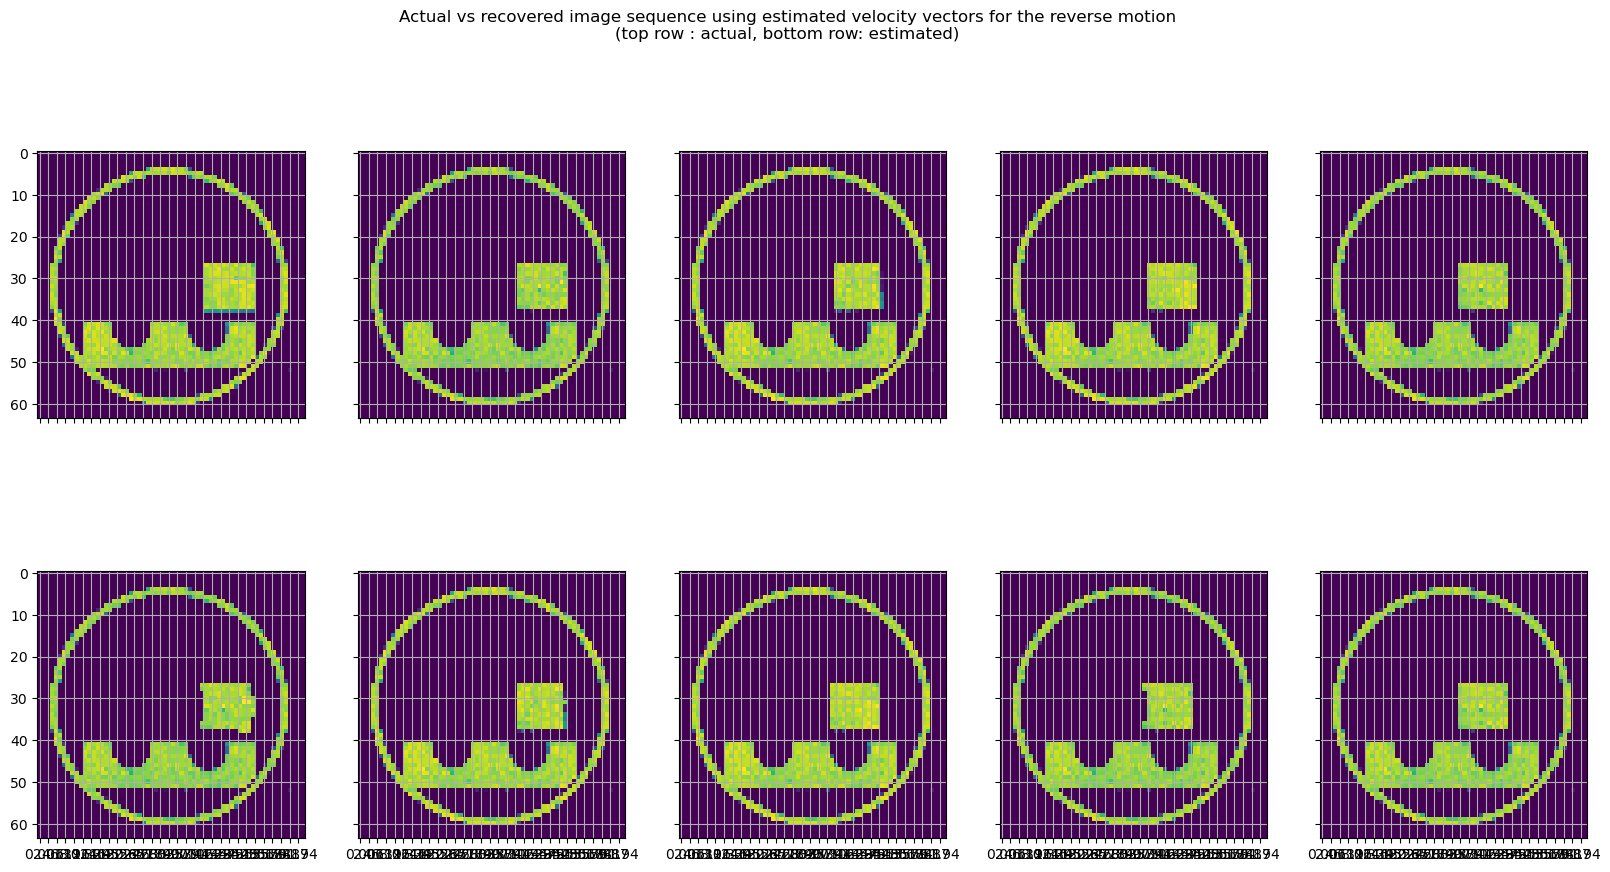

In [53]:
fig,ax=plt.subplots(2,t_end,figsize=(20,10),sharex=True, sharey=True)
vel_shape = shape[0],shape[1],2
#u_traj.reverse()
rec = [u_inv_traj[0].reshape(shape)] + [M(u_inv_traj[i].reshape(shape),(v_ests_c[::-1][i]).reshape(vel_shape)).reshape(shape) for i in range(t_end - 1)]
rec = rec[::-1]
orig = [u_inv_traj[i].reshape(shape)  for i in range(t_end)]
orig = orig[::-1]
for i in range(0,t_end):

    major_ticks = np.linspace(0, 64,32)
    minor_ticks = np.linspace(0, 64,32)

    ax[0,i].set_xticks(minor_ticks,minor=True)
    ax[1,i].set_xticks(minor_ticks, minor=True)
    ax[0,i].set_xticks(major_ticks)
    ax[1,i].set_xticks(major_ticks)
    # ax.set_yticks(minor_ticks, minor=True)

    ax[1,i].imshow(rec[i])
    ax[0,i].imshow(orig[i])

    ax[1,i].grid('minor')
    ax[0,i].grid('major')
    if (i<t_end-1):
        print(np.linalg.norm(orig[i]-rec[i])/np.linalg.norm(orig[i]),np.linalg.norm(vs[i]-v_ests_c[::-1][i].reshape(vel_shape))/np.linalg.norm(vs[i]))

fig.suptitle('Actual vs recovered image sequence using estimated velocity vectors for the reverse motion' + '\n' + '(top row : actual, bottom row: estimated)');

0.7593449449925731 0.810433662361353


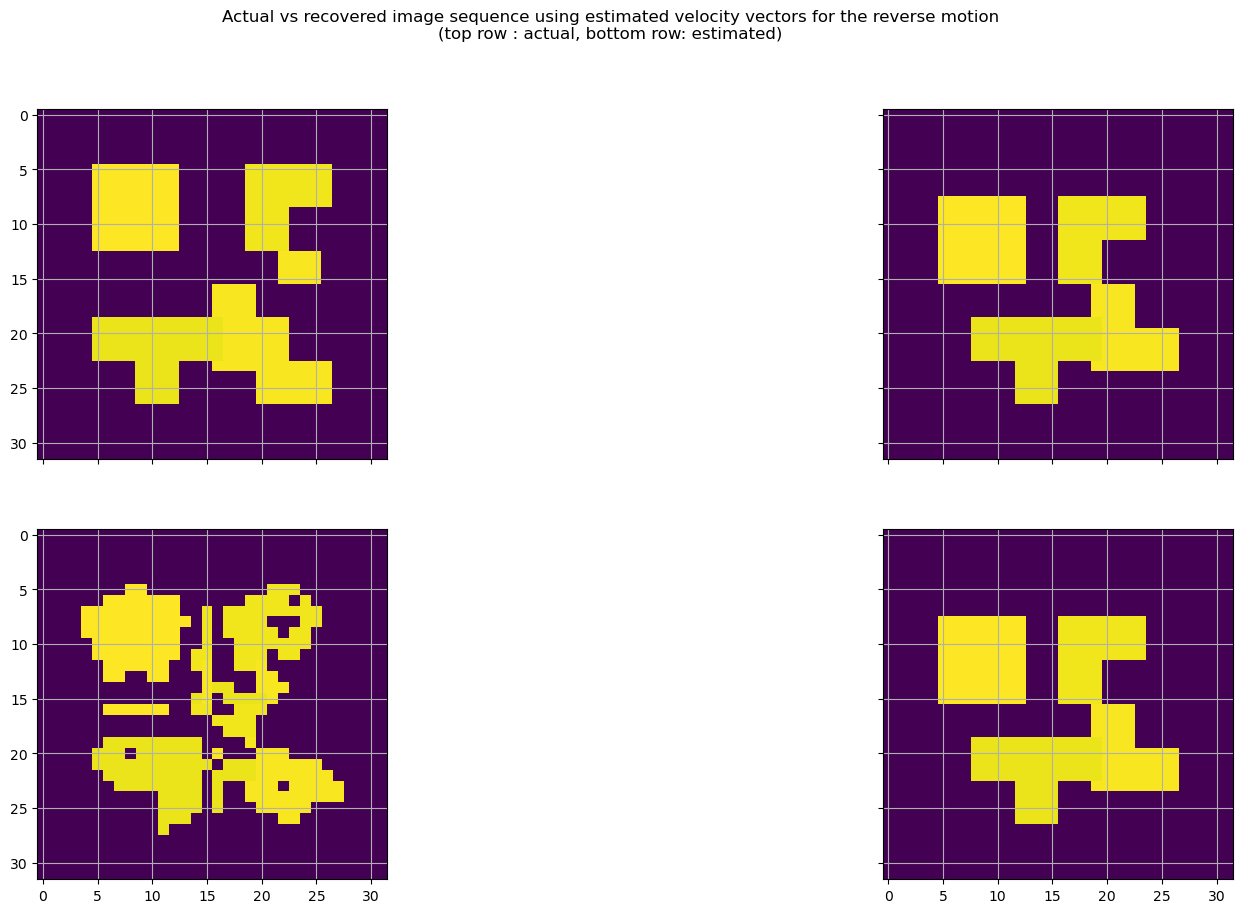

In [346]:
fig,ax=plt.subplots(2,t_end,figsize=(20,10),sharex=True, sharey=True)
vel_shape = shape[0],shape[1],2
#u_traj.reverse()
rec = [u_inv_traj[0].reshape(shape)] + [M(u_inv_traj[i].reshape(shape),(v_ests_c[::-1][i]).reshape(vel_shape)).reshape(shape) for i in range(t_end - 1)]
rec = rec[::-1]
orig = [u_inv_traj[0].reshape(shape)] + [M(u_inv_traj[i].reshape(shape),vs[::-1][i].reshape(vel_shape)).reshape(shape) for i in range(t_end - 1)]
orig = orig[::-1]
for i in range(0,t_end):
    ax[1,i].imshow(rec[i])
    ax[0,i].imshow(orig[i])

    ax[1,i].grid('minor')
    ax[0,i].grid('minor')
    if (i<t_end-1):
        print(np.linalg.norm(orig[i]-rec[i])/np.linalg.norm(orig[i]),np.linalg.norm(vs[i]-v_ests_c[::-1][i].reshape(vel_shape))/np.linalg.norm(vs[i]))

fig.suptitle('Actual vs recovered image sequence using estimated velocity vectors for the reverse motion' + '\n' + '(top row : actual, bottom row: estimated)');

0.9410903146527849 3.098533044761417
0.9287088480332624 2.528522105159688
0.8930529813843502 2.494438257849294
0.90241683204083 3.4791246585919673


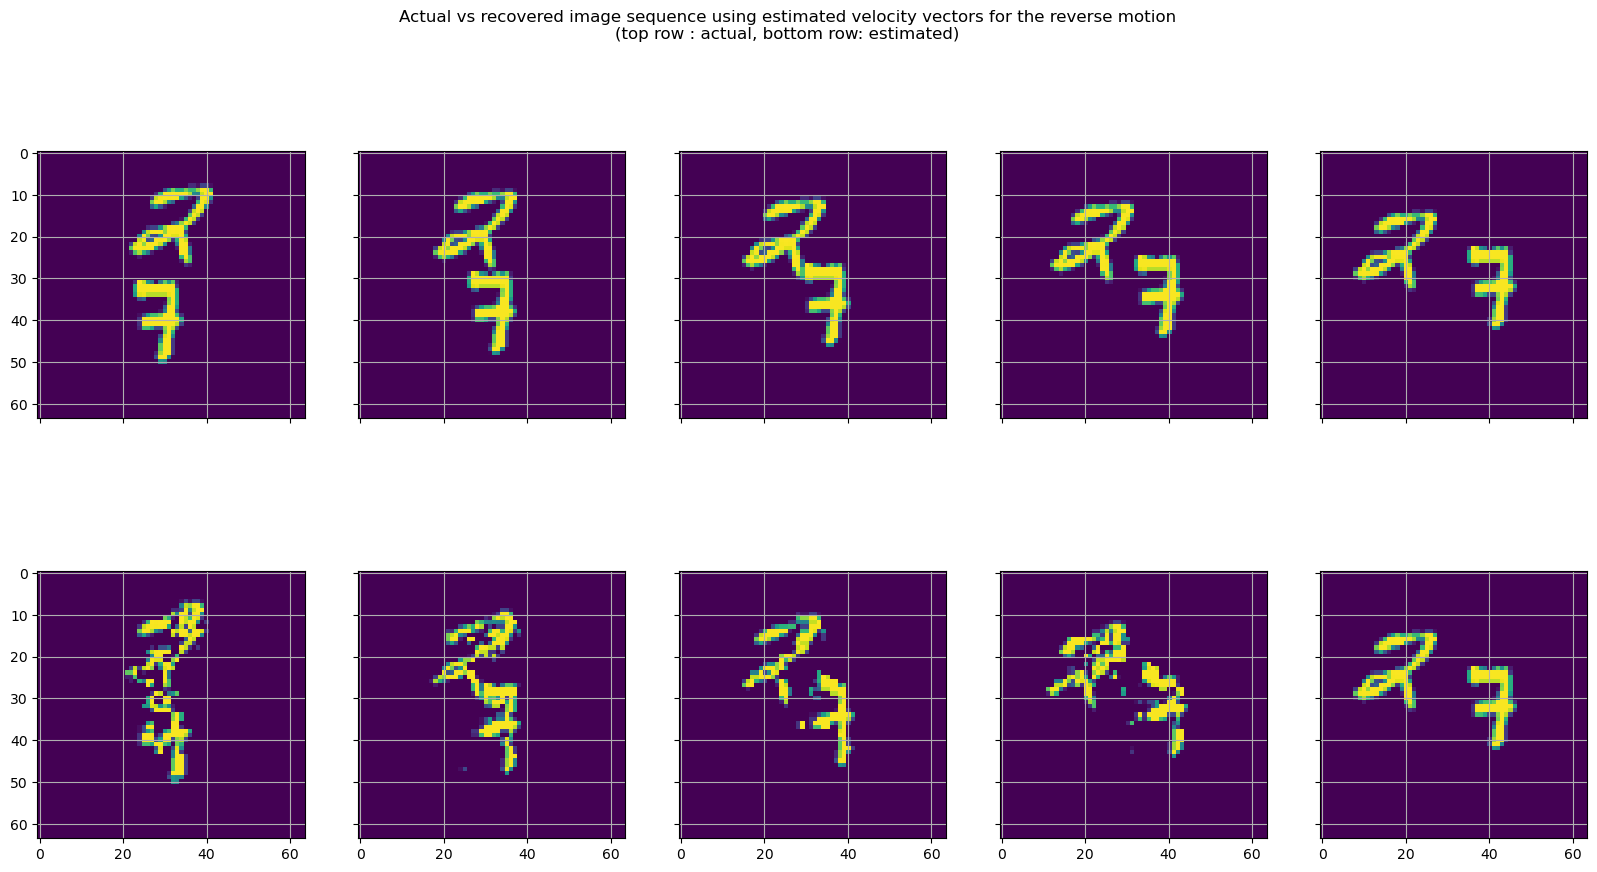

In [266]:
fig,ax=plt.subplots(2,t_end,figsize=(20,10),sharex=True, sharey=True)
vel_shape = shape[0],shape[1],2
#u_traj.reverse()
rec = [u_inv_traj[0].reshape(shape)] + [M(u_inv_traj[i].reshape(shape),(v_ests_c[::-1][i]).reshape(vel_shape)).reshape(shape) for i in range(t_end - 1)]
rec = rec[::-1]
orig = u_inv_traj #[0].reshape(shape)] + [M(u_inv_traj[i].reshape(shape),vs[::-1][i].reshape(vel_shape)).reshape(shape) for i in range(t_end - 1)]
orig = orig[::-1]
for i in range(0,t_end):
    ax[1,i].imshow(rec[i])
    ax[0,i].imshow(orig[i].reshape(shape))

    ax[1,i].grid('minor')
    ax[0,i].grid('minor')
    if (i<t_end-1):
        print(np.linalg.norm(orig[i].reshape(shape)-rec[i])/np.linalg.norm(orig[i]),np.linalg.norm(vs[i]-v_ests_c[::-1][i].reshape(vel_shape))/np.linalg.norm(vs[i]))

fig.suptitle('Actual vs recovered image sequence using estimated velocity vectors for the reverse motion' + '\n' + '(top row : actual, bottom row: estimated)');



0.8750908500611863 7.44252352784894


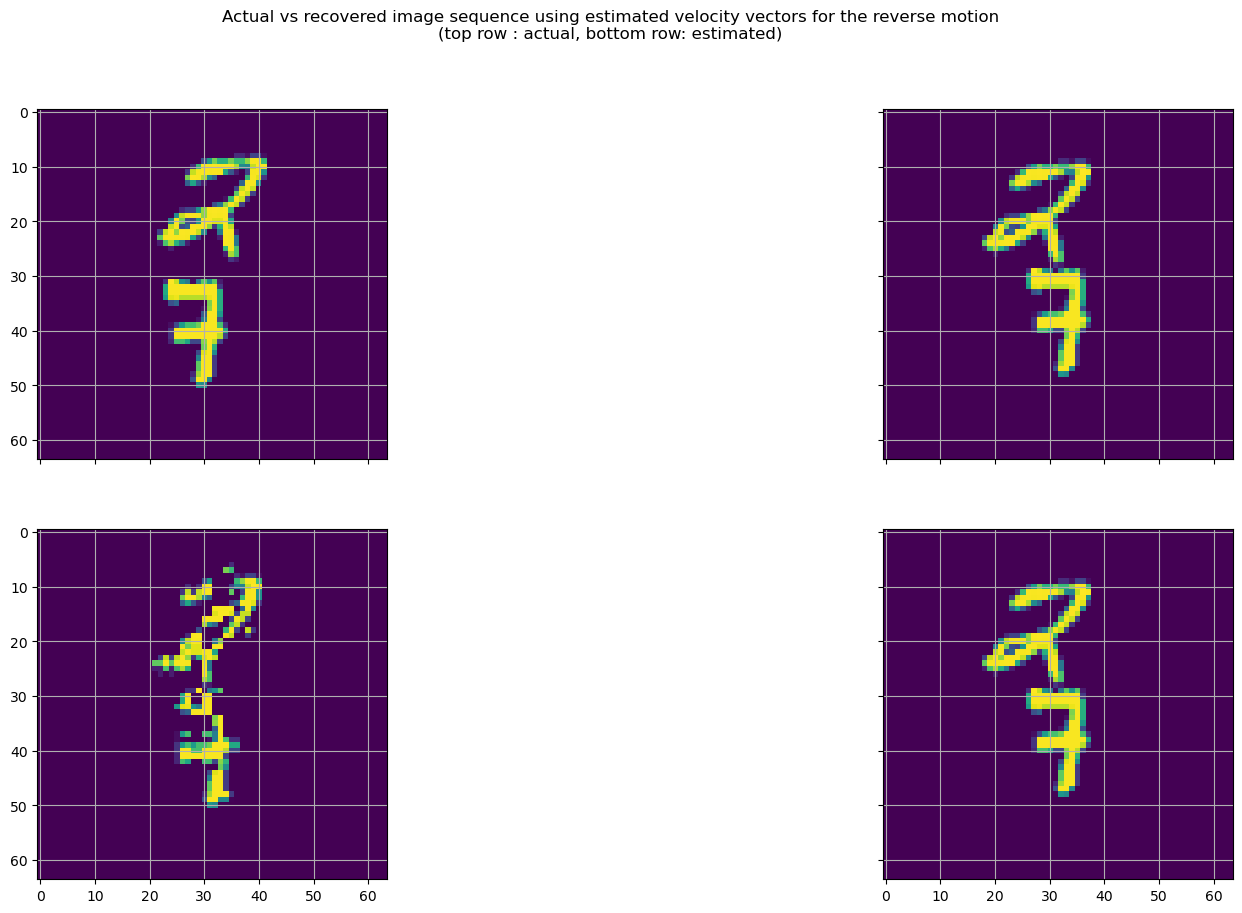

In [248]:
fig,ax=plt.subplots(2,t_end,figsize=(20,10),sharex=True, sharey=True)
vel_shape = shape[0],shape[1],2
#u_traj.reverse()
rec = [u_inv_traj[0].reshape(shape)] + [M(u_inv_traj[i].reshape(shape),(v_ests_c[::-1][i]).reshape(vel_shape)).reshape(shape) for i in range(t_end - 1)]
rec = rec[::-1]
orig = u_inv_traj #[0].reshape(shape)] + [M(u_inv_traj[i].reshape(shape),vs[::-1][i].reshape(vel_shape)).reshape(shape) for i in range(t_end - 1)]
orig = orig[::-1]
for i in range(0,t_end):
    ax[1,i].imshow(rec[i])
    ax[0,i].imshow(orig[i].reshape(shape))

    ax[1,i].grid('minor')
    ax[0,i].grid('minor')
    if (i<t_end-1):
        print(np.linalg.norm(orig[i].reshape(shape)-rec[i])/np.linalg.norm(orig[i]),np.linalg.norm(vs[i]-v_ests_c[::-1][i].reshape(vel_shape))/np.linalg.norm(vs[i]))

fig.suptitle('Actual vs recovered image sequence using estimated velocity vectors for the reverse motion' + '\n' + '(top row : actual, bottom row: estimated)');